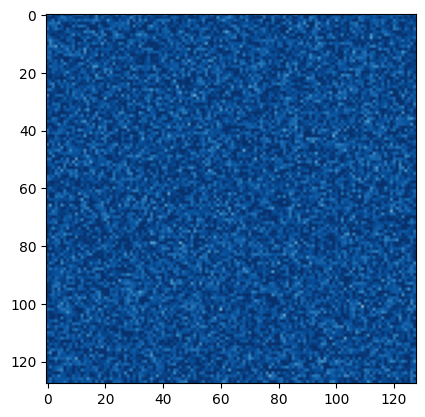

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

size_x = 128
size_y = 128

flat = np.random.normal(0.9,0.1,size=(size_x*size_y))
colors = colormaps.get("Blues")(flat)
bmp = colors.reshape((size_x,size_y,4))
plt.imshow(bmp)
plt.imsave("ocean_00.png", bmp, dpi=64/256*100)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from noise import pnoise2

# Settings
size = 256          # output size
scale = 50.0        # controls wave size
octaves = 4         # number of noise layers
persistence = 0.5   # amplitude decay per octave
lacunarity = 2.0    # frequency increase per octave

# Generate tileable Perlin noise
bmp = np.zeros((size, size))
for y in range(size):
    for x in range(size):
        # Sum multiple octaves for more realistic waves
        value = 0
        frequency = 1
        amplitude = 1
        max_value = 0
        for _ in range(octaves):
            value += amplitude * pnoise2(
                x / scale * frequency,
                y / scale * frequency,
                repeatx=size,
                repeaty=size,
                base=0
            )
            max_value += amplitude
            amplitude *= persistence
            frequency *= lacunarity
        bmp[y, x] = value / max_value

# Normalize to [0,1]
bmp = (bmp - bmp.min()) / (bmp.max() - bmp.min())

# Ocean colormap (deep blue → teal → light blue → white)
ocean_colors = LinearSegmentedColormap.from_list(
    "ocean",
    [
        (0.0, "#001933"),
        (0.4, "#004488"),
        (0.7, "#0099cc"),
        (0.9, "#66ddee"),
        (1.0, "#ffffff"),
    ],
)

# Save the seamless tile
plt.imsave("ocean_tileable.png", bmp, cmap=ocean_colors)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2
import os

# Settings

tile_size = 256           # final tile tile_size
scale = 32.0         # controls wave tile_size
octaves = 3          # layers of noise

terrain_palette = {
    "ocean": [
        "#001933",  # deep ocean
        "#023160",  # mid ocean
        "#004488",  # mid ocean
        "#0353A2",  # mid ocean
        "#0099cc",  # teal
        "#66ddee",  # light
    ],
    "lake": [
        "#0E4068",  # deep lake (dark navy)
        "#18588D",  # mid-deep blue
        "#2B5C7D",  # medium blue
        "#3E82A6",  # lighter blue
        "#70AFC2",  # tealish/light blue
        "#A0D4E1",  # shallow water / highlight
    ],
    "beach": [
        "#FDF5E6",  # very pale sand (dry, top layer)
        "#FCE7C7",  # light sand
        "#F8D9A3",  # mid sand
        "#F2C97B",  # golden sand
        "#E6B35C",  # wet sand near water
        "#D9A143",  # darker wet sand / edges
    ],
    "grassland" : [
        "#2C5F2D",  # dark base grass
        "#3E7D3F",  # mid green
        "#5EA86B",  # lighter green
        "#7FCF8D",  # sunlit grass
        "#A2E5B0",  # highlight/soft grass
        "#C4F2CC",  # very light/young grass
    ]
}

grid_size = 10       # 10x10 grid
num_tiles = 10       # number of different tiles

for terrain, palette in terrain_palette.items():
    os.makedirs(terrain, exist_ok=True)
    tiles = []
    for base in range(num_tiles):

        # Generate seamless Perlin noise
        bmp = np.zeros((tile_size, tile_size))
        for y in range(tile_size):
            for x in range(tile_size):
                value = 0
                frequency = 1
                amplitude = 1
                max_value = 0
                for _ in range(octaves):
                    value += amplitude * pnoise2(
                        x / scale * frequency,
                        y / scale * frequency,
                        repeatx=tile_size,   # ensures left/right edges match
                        repeaty=tile_size,   # ensures top/bottom edges match
                        base=base
                    )
                    max_value += amplitude
                    amplitude *= 0.5
                    frequency *= 2
                bmp[y, x] = value / max_value

        # Normalize to [0,1]
        bmp = (bmp - bmp.min()) / (bmp.max() - bmp.min())

        # Quantize to palette
        n_colors = len(palette)
        bmp_quantized = (bmp * (n_colors - 1)).astype(int)

        # Convert to RGB array
        rgb_array = np.zeros((tile_size, tile_size, 3), dtype=np.uint8)
        for i, color in enumerate(palette):
            rgb_array[bmp_quantized == i] = np.array([int(color[1:3],16), int(color[3:5],16), int(color[5:7],16)])

        tiles.append(rgb_array)
        # Save the seamless pixel-art tile
        plt.imsave(f"{terrain}/{terrain}_{base:02d}.png", rgb_array)


    grid = np.zeros((tile_size * grid_size, tile_size * grid_size, 3), dtype=np.uint8)
    for y in range(grid_size):
        for x in range(grid_size):
            tile = tiles[np.random.randint(0, num_tiles)]
            grid[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size] = tile

    # Save the final grid
    plt.imsave(f"{terrain}/{terrain}_grid.png", grid)

